## Q1


Setup

In [1]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
# make it easier to understand by importing the required libraries within keras
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import KFold
import random as random
import pandas as pd
from sklearn.model_selection import train_test_split


f1(𝑥) =  𝑥 ∗ sin(6𝜋𝑥) ∗ exp(−𝑥^2) 𝑤ℎ𝑒𝑟𝑒 𝑥 ∈ [−1, 1]


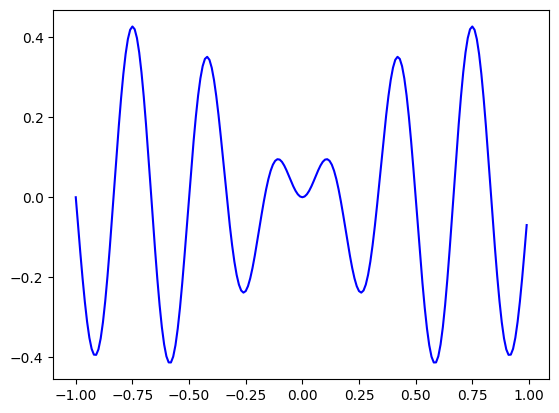

In [2]:
def f1(x):
    return x*np.sin(6*np.pi*x)*np.exp(-(x**2))

x = np.arange(-1, 1, 0.01)
y = f1(x)
plt.plot(x, y, 'b')

f2(𝑥) = exp(−𝑥^2) ∗ arctan(𝑥) ∗ sin(4𝜋𝑥) 𝑤ℎ𝑒𝑟𝑒 𝑥 ∈ [−2, 2]


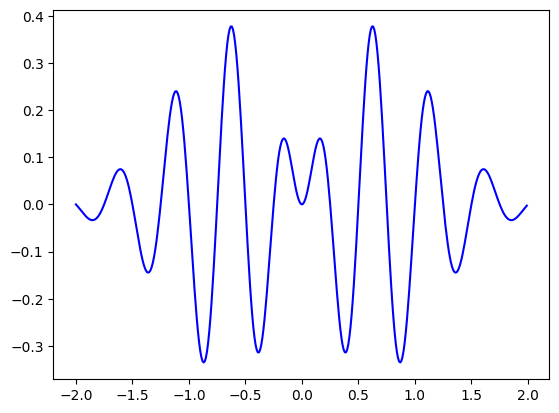

In [3]:
def f2(x):
    return np.exp(-(x**2))*np.arctan(x)*np.sin(4*np.pi*x)

x = np.arange(-2, 2, 0.01)
y = f2(x)
plt.plot(x, y, 'b')

Data Generation for function 1, where data where initially seperated into 80% training and 20% testing

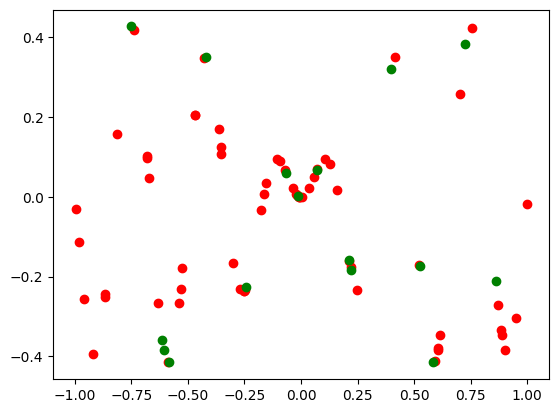

In [4]:

def generatef1(n):
    x = np.empty(n)
    y = np.empty(n)

    for i in range(n):
        x[i] = random.uniform(-1, 1)
        y[i] = f1(x[i])       
        
    # 80% for training, 20% for testing
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = generatef1(80)

plt.scatter(x_train, y_train, c="r")
plt.scatter(x_test, y_test, c="g")


Function for comparing the output of regression model against function 1 using line approximation. 

In [5]:
def evaluatef1(model):
    # make prediction using new dataset
    x_train, x_test, y_train, y_test = generatef1(100)
    prediction = model.predict(x_test)
    
    # generate best fit approximation line using predicted value
    coefficients = np.polyfit(x_test, prediction.flatten(), 16)
    line = np.poly1d(coefficients)
    x_line = np.linspace(min(x_test), max(x_test), 100)
    y_line = line(x_line)

    # plot the data points and the line approximation
    plt.scatter(x_test, prediction.flatten(), c="r")
    plt.plot(x_line, y_line, '-g', label='Line approximation')

    # plot the original function
    x = np.arange(-1, 1, 0.01)
    y = f1(x)
    plt.plot(x, y, 'b')
        

Data Generaton for function 2, where data where initially seperated into 80% training and 20% testing

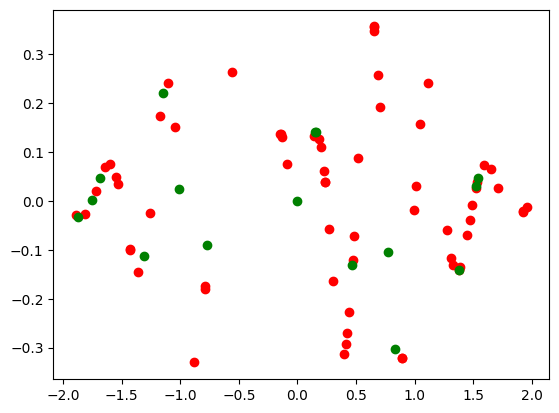

In [6]:
def generatef2(n):
    x = np.empty(n)
    y = np.empty(n)

    for i in range(n):
        x[i] = random.uniform(-2, 2)
        y[i] = f2(x[i])       
        
    # 80% for training, 20% for testing
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = generatef2(80)

plt.scatter(x_train, y_train, c="r")
plt.scatter(x_test, y_test, c="g")


Function for comparing the output of regression model against function 2 using line approximation. 

In [7]:
def evaluatef2(model):
    # make prediction using new dataset
    x_train, x_test, y_train, y_test  = generatef2(100)
    prediction = model.predict(x_test)
    
    # best fit curve 
    coefficients = np.polyfit(x_test, prediction.flatten(), 6)
    line = np.poly1d(coefficients)
    x_line = np.linspace(min(x_test), max(x_test), 100)
    y_line = line(x_line)

    # plot the data points and the line approximation
    plt.scatter(x_test, prediction.flatten(), c="r")
    plt.plot(x_line, y_line, '-g', label='Line approximation')

    # plot the original function
    x = np.arange(-2, 2, 0.01)
    y = f2(x)
    plt.plot(x, y, 'b')

Function for training the model, since this is a regression model we use mean square error as the loss function to penalize large errors more than small errors. Here I used 50 epochs and random shuffling to make sure the model is not underfitting. Furthermore, a 10-fold cross validation is also implemented to compute the validation loss, this is used by the early stopping callback function to prevent overfitting. 

In [8]:
def fit(model, x_train, y_train, x_val, y_val, x_test, y_test):
    # early stopping mechanism
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')

    # mean square error for loss function, rest is default
    model.compile(loss='mse', optimizer='adam')
    
    h = model.fit(x_train, y_train, epochs=400, batch_size=1, callbacks=[callback], shuffle=True, verbose=0, validation_data=(x_val, y_val))
    
    # print('Test accuracy: %.2f %%'%(100*model.evaluate(x_test,y_test, verbose=0)[1]))
    
    # return the average training error and validation error for analysis 
    return np.array(h.history['loss']).mean(), np.array(h.history['val_loss']).mean()

Function for generating a 4x4 grid of training error and validation error comparing different combination of sample size and number of hidden nodes

In [9]:
def generateGrid(data):
    # create the dataframe
    df = pd.DataFrame(data, columns=["10", "40", "80", "200"],
                    index=["2", "10", "40", "100"])

    # print the dataframe
    print(df)

## Q1.a


Regression model for function 1. After testing differnt combination functions I decided to use relu as activation function since it returns the lowest averge training error. As per instruction a 10-fold validation is implemented and repeated 5 times to find the smallest average trainig and validation error.

In [10]:
n_samples = [10, 40, 80, 200] 
n_neurons = [2, 10, 40, 100]

M1 = np.empty((len(n_samples), len(n_neurons)), dtype=object)
error1 = np.empty((len(n_samples), len(n_neurons)), dtype=tuple)

for i in range(len(n_samples)):
    for j in range(len(n_neurons)):
        # generat dataset
        x_train, x_test, y_train, y_test = generatef1(n_samples[i])
        # model initialization
        M1[i,j] = keras.models.Sequential()
        # input layer + hidden layer
        M1[i,j].add(Dense(n_neurons[j], activation='relu', input_shape=(1,)))
        # output layer
        M1[i,j].add(Dense(1, activation='linear'))
        
        min_error = 100
        for k in range(5):
            # 10 fold cross validation
            n_split = 10
            if len(x_train) < n_split:
                n_split = len(x_train)
            kf = KFold(n_splits=n_split)
            kf.get_n_splits(x_train)
            
            # for recording average loss
            training_loss = np.empty(n_split)
            validation_loss = np.empty(n_split)

            counter = 0
            # iterate through all folds
            for train_index, val_index in kf.split(x_train):
                X_train, X_val = x_train[train_index], x_train[val_index]
                Y_train, Y_val = y_train[train_index], y_train[val_index]
                # train 
                training_loss[counter], validation_loss[counter] = fit(M1[i,j], X_train, Y_train, X_val, Y_val, x_test, y_test)
                counter += 1
                
            # find minimum training error and validation error
            if np.mean(training_loss) + np.mean(validation_loss) < min_error:
                min_error = np.mean(training_loss) + np.mean(validation_loss)
                error1[i,j] = (np.mean(training_loss), np.mean(validation_loss))
         
generateGrid(error1)          

                                              10  \
2     (0.08929389854893088, 0.09285706436700517)   
10   (0.049341233533069295, 0.05122091260926145)   
40     (0.0544043430685997, 0.05487542333081365)   
100   (0.06275722263380885, 0.06263195840020974)   

                                              40  \
2     (0.04573742477999379, 0.04867036812162648)   
10   (0.046124506185629535, 0.04573218557118837)   
40   (0.05038843967463998, 0.051458163594472264)   
100   (0.05394472921492928, 0.05504661715899904)   

                                               80  \
2    (0.006035525359038729, 0.008142647228412514)   
10     (0.06385716236595597, 0.06860110477788287)   
40    (0.05985455729481247, 0.061633277609944345)   
100    (0.04716166024613712, 0.04734322128093077)   

                                              200  
2      (0.03661020629307521, 0.05641833011111702)  
10    (0.035415091193825396, 0.04006491247809606)  
40    (0.037785654156542725, 0.03962409865731994)  
100 

Regression model for function 2. After testing differnt combination functions I decided to use relu as activation function since it returns the lowest averge training error. As per instruction a 10-fold validation is implemented and repeated 5 times to find the smallest average trainig and validation error.

In [11]:
n_samples = [10, 40, 80, 200] 
n_neurons = [2, 10, 40, 100]

M2 = np.empty((len(n_samples), len(n_neurons)), dtype=object)
error2 = np.empty((len(n_samples), len(n_neurons)), dtype=tuple)

for i in range(len(n_samples)):
    for j in range(len(n_neurons)):
        # generate dataset
        x_train, x_test, y_train, y_test = generatef2(n_samples[i])
        # model initialization
        M2[i,j] = keras.models.Sequential()
        # input layer + hidden layer
        M2[i,j].add(Dense(n_neurons[j], activation='relu', input_shape=(1,)))
        #output layer
        M2[i,j].add(Dense(1, activation='linear'))
        
        min_error = 100
        for k in range(5):        
            # 10 fold cross validation
            n_split = 10
            if len(x_train) < n_split:
                n_split = len(x_train)
            kf = KFold(n_splits=n_split)
            kf.get_n_splits(x_train)
            
            # for recording averge loss
            training_loss = np.empty(n_split)
            validation_loss = np.empty(n_split)
            
            counter = 0
            # iterate through all folds
            for train_index, val_index in kf.split(x_train):
                X_train, X_val = x_train[train_index], x_train[val_index]
                Y_train, Y_val = y_train[train_index], y_train[val_index]
                # train 
                training_loss[counter], validation_loss[counter] = fit(M2[i,j], X_train, Y_train, X_val, Y_val, x_test, y_test)
                counter += 1
                
            # find minimum training error and validation error
            if np.mean(training_loss) + np.mean(validation_loss) < min_error:
                min_error = np.mean(training_loss) + np.mean(validation_loss)
                error2[i,j] = (np.mean(training_loss), np.mean(validation_loss))
                
generateGrid(error2)

                                              10  \
2    (0.049667633028151706, 0.04973094584112395)   
10   (0.03153214517330366, 0.031662354596875726)   
40   (0.027994273264581954, 0.02820718091705607)   
100   (0.02695705468056812, 0.02701357950057302)   

                                               40  \
2    (0.006913974674280903, 0.008526136244872471)   
10   (0.016901148182694756, 0.017894534423082538)   
40   (0.023498357709585912, 0.024407576238403898)   
100  (0.028471514934984343, 0.028669815780594944)   

                                               80  \
2    (0.010248077889194802, 0.016515552371825306)   
10   (0.027169278007266772, 0.030128592072768016)   
40    (0.02789276196976148, 0.028427449334412817)   
100  (0.023576122920161913, 0.023473798566098724)   

                                              200  
2     (0.018496689433717014, 0.02922710624255463)  
10   (0.014890141873876309, 0.015625352556164797)  
40     (0.03013823595208427, 0.03250591102987528)  

## Q1.b

For function 1, the model with 10 hidden nodes and 80 samples shows the best average training and validation error of 0.0336 while having a complex enough model. The following chart shows its prediction using 20 fresh data, compared to the original function

(0.06385716236595597, 0.06860110477788287)
1/1 [==============================] - 0s 134ms/step


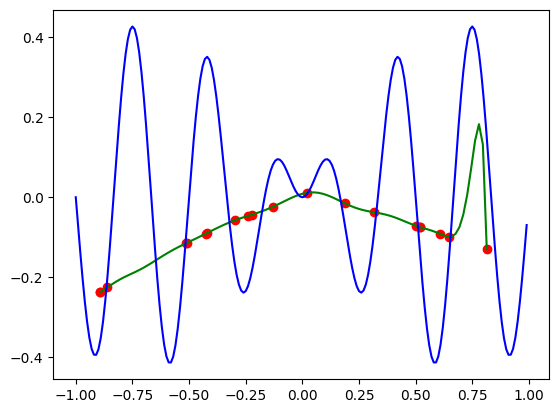

In [12]:
print(error1[1 , 2])
evaluatef1(M1[1 , 2])

For function 2, the model with 100 hidden nodes and 80 samples shows the best average training and validation error of 0.0207 while having a complex enought model. The following chart shows its prediction using fresh data, compared to the original function

(0.023576122920161913, 0.023473798566098724)
1/1 [==============================] - 0s 39ms/step


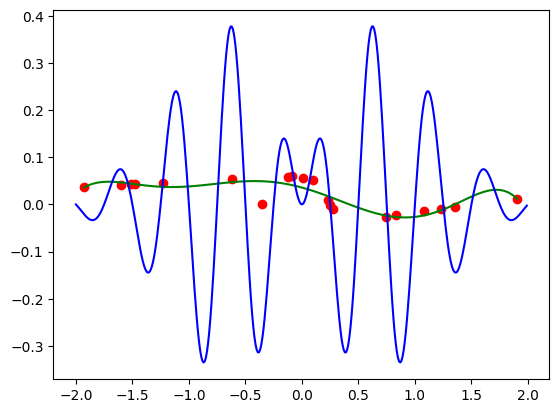

In [13]:
print(error2[3, 2])
evaluatef2(M2[3, 2])

## Q1.c

From both models and it average error gird, we can see that the average error for the model with small samples and neurons are higher than the rest, indicating that it is underfit since it does not have enough data or node to sufficiently train on. The same can be said for the model on the opposite end, indicating that it is overfit because it has memorized the pattern instead of learning it. The best model of both function lies in the middle, since it has the best balance between variance and bias. 